## 第一步 导入必要的包

In [1]:
import pandas as pd
# 
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
# 忽略不必要的warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import re
# nltk：文本处理的包
from nltk.stem.wordnet import WordNetLemmatizer # 词性还原
from collections import Counter
import math
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn

# gensim：主题模型库
from gensim.models import Word2Vec,KeyedVectors
import gensim,nltk
from gensim import corpora
from gensim.similarities import Similarity

#from pyecharts.globals import CurrentConfig
from pyecharts.globals import CurrentConfig, OnlineHostType
CurrentConfig.ONLINE_HOST = OnlineHostType.NOTEBOOK_HOST
import pyecharts.options as opts
from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType


## 第二步，载入数据

In [2]:
df=pd.read_csv('reviews.csv')

In [3]:
df.head()

,stars,date,type,short_d,content,product_name,name
0,2.0 out of 5 stars,"Reviewed in the United States on June 24, 2020",Rainbow String,For children,"This is for children, not adults. I cannot use...",everjoys-Soprano,Kathy
1,1.0 out of 5 stars,"Reviewed in the United States on June 24, 2020",Rainbow String,Returned.,Impossible to tune.,everjoys-Soprano,Pam Palumbo
2,4.0 out of 5 stars,"Reviewed in the United States on June 22, 2020",Mahogany,Nice,Very nice product! The ukulele is very light a...,everjoys-Soprano,andy
3,5.0 out of 5 stars,"Reviewed in the United States on June 20, 2020",Rainbow String,Buy it,It was a great guitar for beginning guitar pla...,everjoys-Soprano,Donna
4,2.0 out of 5 stars,"Reviewed in the United States on June 18, 2020",Rainbow String,Wouldn't hold a tune,"It is a cute little ukulele, but is poor quali...",everjoys-Soprano,Amazon Customer


In [4]:
df.isnull().any()

stars           False
date            False
type            False
short_d          True
content          True
product_name    False
name             True
dtype: bool

## 第三步，数据处理

In [5]:
# 对于评论内容空缺的，世界删除
df=df.dropna(axis=0, how='any', subset=['content'], inplace=False)

# 评论数字化
def get_stars(n):
    return float(n.replace(' out of 5 stars',''))

# 评论的极性
def stars_cat(n):
    if n<=2:
        return 'negative'
    elif n==3:
        return 'neutral'
    return 'positive'

# str的处理的主要的方法，replace、split
def get_date(x):
    x=x.replace('Reviewed in the United States on ','').replace(',','')
    tt=x.split(' ')
    m,n,p = tt[0],tt[1],tt[2] #i month,j day,k year
    #return n    
    if m=='October' or m=='Oktober' or m=='Oct' or m=='Okt':
        on_date='10-'+n+'-'+p
    elif m=='September' or m=='Sep':
        on_date='09-'+n+'-'+p
    elif m=='June' or m=='Jun':
        on_date='06-'+n+'-'+p
    elif m=='December' or m=='Dezember' or m=='Dec' or m=='Dez':
        on_date='12-'+n+'-'+p
    elif m=='July' or m=='Juli' or m=='Jul':
        on_date='07-'+n+'-'+p
    elif m=='May' or m=='Mai':
        on_date='05-'+n+'-'+p
    elif m=='April' or m=='Apr':
        on_date='04-'+n+'-'+p
    elif m=='February' or m=='Februar' or m=='Feb':
        on_date='02-'+n+'-'+p
    elif m=='March' or m=='März' or m=='Maerz' or m=='Mar':
        on_date='03-'+n+'-'+p
    elif m=='November' or m=='Nov':
        on_date='11-'+n+'-'+p
    elif m=='August' or m=='Aug':
        on_date='08-'+n+'-'+p
    elif m=='January' or m=='Januar' or m=='Jan':
        on_date='01-'+n+'-'+p    
    on_date=datetime.datetime.strptime(on_date, '%m-%d-%Y').strftime('%Y-%m-%d')
    return on_date

# 字数统计
df['stars_num']=df['stars'].apply(get_stars)
df['content_cat']=df['stars_num'].apply(stars_cat)
df['date_d']=df['date'].apply(get_date)

# 发布时间趋势
df.to_csv('lesson6_c.csv')

In [6]:
df

,stars,date,type,short_d,content,product_name,name,stars_num,content_cat,date_d
0,2.0 out of 5 stars,"Reviewed in the United States on June 24, 2020",Rainbow String,For children,"This is for children, not adults. I cannot use...",everjoys-Soprano,Kathy,2.0,negative,2020-06-24
1,1.0 out of 5 stars,"Reviewed in the United States on June 24, 2020",Rainbow String,Returned.,Impossible to tune.,everjoys-Soprano,Pam Palumbo,1.0,negative,2020-06-24
2,4.0 out of 5 stars,"Reviewed in the United States on June 22, 2020",Mahogany,Nice,Very nice product! The ukulele is very light a...,everjoys-Soprano,andy,4.0,positive,2020-06-22
3,5.0 out of 5 stars,"Reviewed in the United States on June 20, 2020",Rainbow String,Buy it,It was a great guitar for beginning guitar pla...,everjoys-Soprano,Donna,5.0,positive,2020-06-20
4,2.0 out of 5 stars,"Reviewed in the United States on June 18, 2020",Rainbow String,Wouldn't hold a tune,"It is a cute little ukulele, but is poor quali...",everjoys-Soprano,Amazon Customer,2.0,negative,2020-06-18
...,...,...,...,...,...,...,...,...,...,...
5072,1.0 out of 5 stars,"Reviewed in the United States on December 1, 2017",Tenor,... bridge is to low causing the strings to ra...,The product arrived with the Fretboard cracked...,donner,Addm,1.0,negative,2017-12-01
5073,5.0 out of 5 stars,"Reviewed in the United States on December 1, 2017",Tenor,Good Value,Good finishing. Wish the bag's zipper went al...,donner,John,5.0,positive,2017-12-01
5074,5.0 out of 5 stars,"Reviewed in the United States on November 30, ...",Soprano,Five Stars,Very happy with the quality of it.,donner,Salvador Ruiz,5.0,positive,2017-11-30
5075,5.0 out of 5 stars,"Reviewed in the United States on November 30, ...",Concert,Five Stars,I like the looks of the ukulele and the tone.,donner,Amazon Customer,5.0,positive,2017-11-30


## 第四步 非文本类数据的EDA

- sample产品的评论数量
- sample产品下不同类型的产品数量
- sample产品评论星级分布
- ...


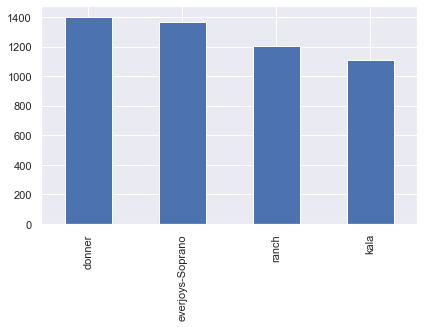

In [7]:
# 数量变化
# 不同asin的总数
sns.set(font_scale=1)
df['product_name'].value_counts().plot(kind='bar')

In [8]:
# 时序相关
# 发文数量分布
df['date_d']=pd.to_datetime(df['date_d'])
df['y_m']=pd.to_datetime(df['date_d'].dt.year.astype(str)+'-'+df['date_d'].dt.month.astype(str)+'-01')

In [9]:
df.head()

,stars,date,type,short_d,content,product_name,name,stars_num,content_cat,date_d,y_m
0,2.0 out of 5 stars,"Reviewed in the United States on June 24, 2020",Rainbow String,For children,"This is for children, not adults. I cannot use...",everjoys-Soprano,Kathy,2.0,negative,2020-06-24,2020-06-01
1,1.0 out of 5 stars,"Reviewed in the United States on June 24, 2020",Rainbow String,Returned.,Impossible to tune.,everjoys-Soprano,Pam Palumbo,1.0,negative,2020-06-24,2020-06-01
2,4.0 out of 5 stars,"Reviewed in the United States on June 22, 2020",Mahogany,Nice,Very nice product! The ukulele is very light a...,everjoys-Soprano,andy,4.0,positive,2020-06-22,2020-06-01
3,5.0 out of 5 stars,"Reviewed in the United States on June 20, 2020",Rainbow String,Buy it,It was a great guitar for beginning guitar pla...,everjoys-Soprano,Donna,5.0,positive,2020-06-20,2020-06-01
4,2.0 out of 5 stars,"Reviewed in the United States on June 18, 2020",Rainbow String,Wouldn't hold a tune,"It is a cute little ukulele, but is poor quali...",everjoys-Soprano,Amazon Customer,2.0,negative,2020-06-18,2020-06-01


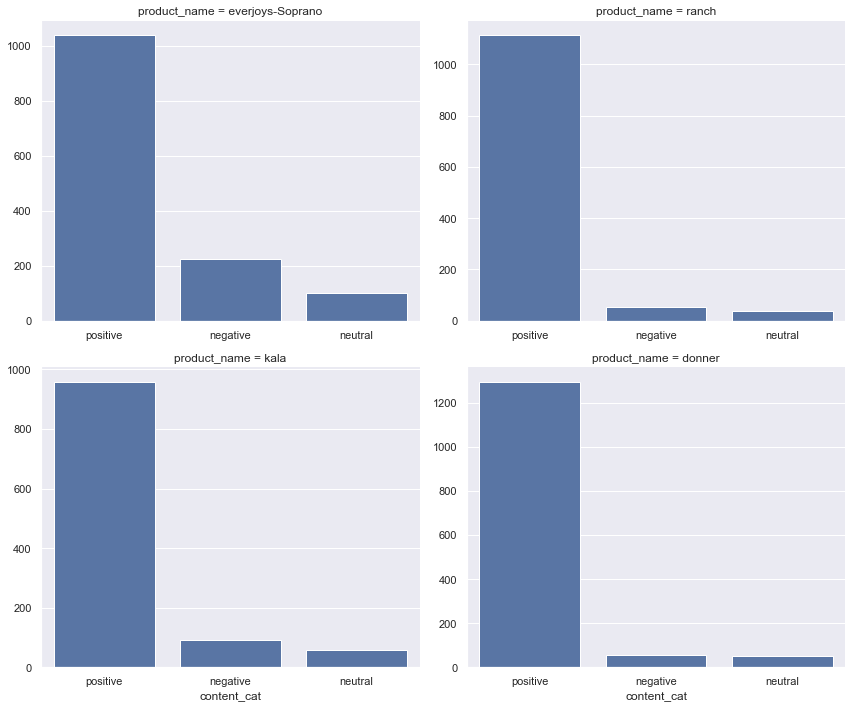

In [11]:
# 不同产品的分类 有点
# 构建结构化多绘图网格,不同子集上绘制同一图的多个实例, --> FacetGrid()
g=sns.FacetGrid(data=df,col='product_name',col_wrap=2,sharex=False,sharey=False,height=5,aspect=1.2)
# 调用FacetGrid.map()或将一个或多个绘图函数应用于每个子集
g.map(sns.countplot,'content_cat', order=['positive','negative','neutral'])


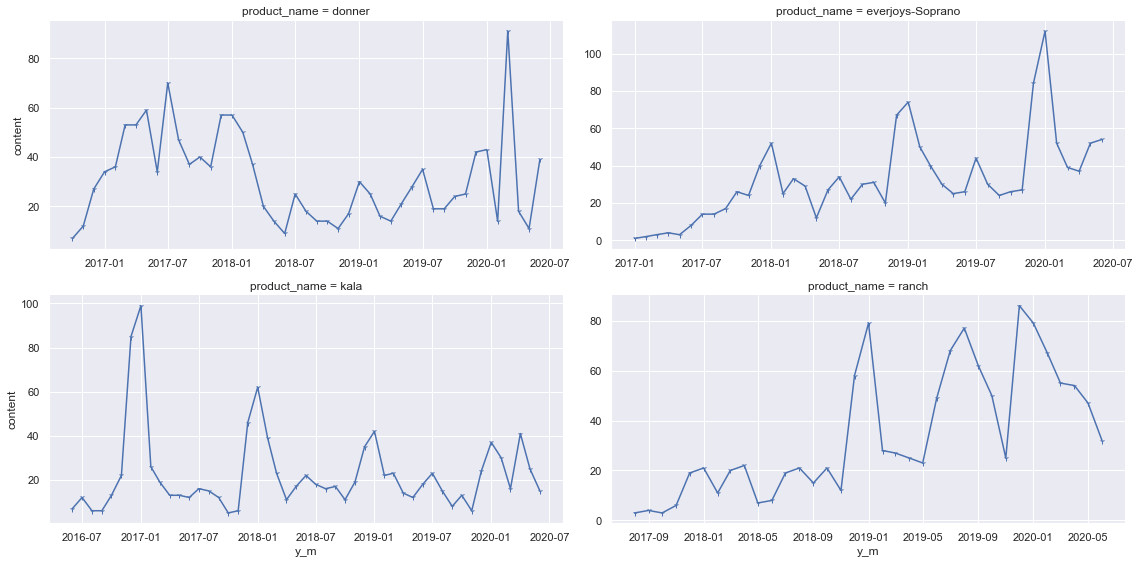

In [12]:
# 每种产品的发文数量按月统计
df_content=df.groupby(['product_name','y_m'])['content'].count().reset_index()
g=sns.FacetGrid(data=df_content,col='product_name',col_wrap=2,sharey=False,sharex=False,height=4,aspect =2)
g.map(plt.plot,"y_m",'content',marker='1')

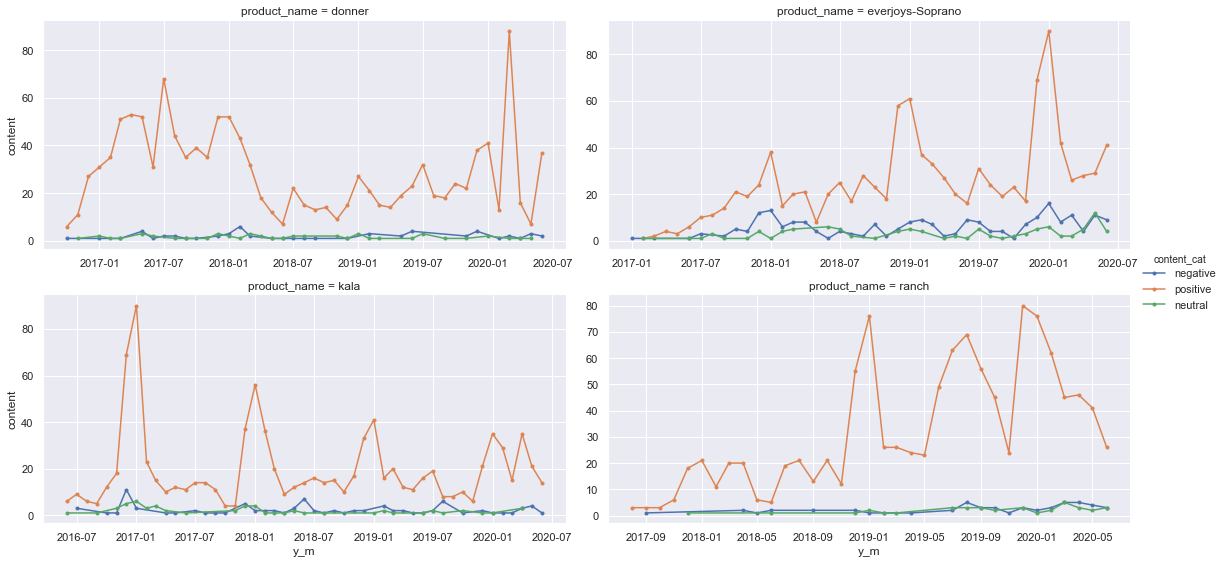

In [13]:
# 好中差评的随时间分布
df_content=df.groupby(['product_name','y_m','content_cat'])['content'].count().reset_index()
g=sns.FacetGrid(data=df_content,col='product_name',hue='content_cat',col_wrap=2,sharey=False,sharex=False,height=4,aspect =2)
g.map(plt.plot,"y_m",'content',marker='.')
g.add_legend()

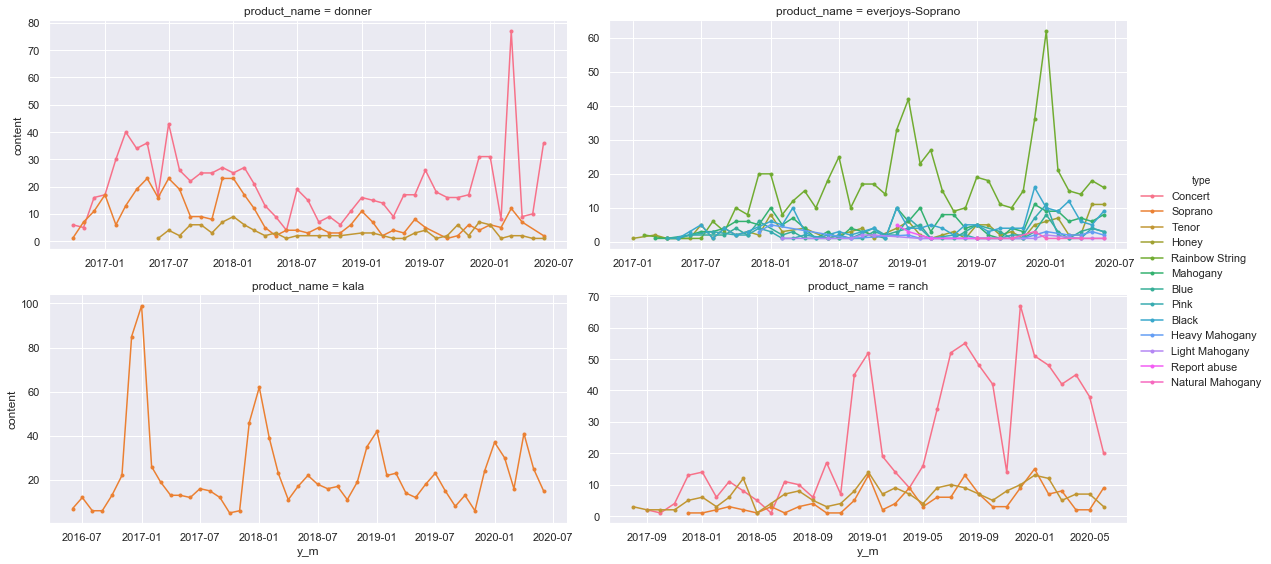

In [13]:
# 同产品不同型号的分布
df_content=df.groupby(['product_name','y_m','type'])['content'].count().reset_index()
g=sns.FacetGrid(data=df_content,col='product_name',hue='type',col_wrap=2,sharey=False,sharex=False,height=4,aspect =2)
g.map(plt.plot,"y_m",'content',marker='.')
g.add_legend()

## 第五步文本挖掘

In [16]:
# 排重
df_data = df.drop_duplicates(subset={"product_name","type","date_d","content_cat","content","stars_num","name"})
df_text=df_data['content']
df_text[0]

"This is for children, not adults. I cannot use the tuner, so I use one on my phone. It doesn't stay in tune longer than a couple minutes."

In [17]:
# 比如是某一款产品的好的评论/差的评论
sample_positive=df_data[(df_data.product_name=='everjoys-Soprano') & (df_data.content_cat=='positive')]
sample_negative=df_data[(df_data.product_name=='everjoys-Soprano') & (df_data.content_cat=='negative')]

In [18]:
len(sample_positive)

1039

In [19]:
len(sample_negative)

223

5.1 文本处理手段：
- 还原常见缩写单词还原
- 词性还原
- 去停

In [20]:
# 在用语料分析的第一步，对文本进行处理，正则表达式
# 正则：由一系列普通与特殊字符组成的用于描述文本规则的表达式
# re的包，是一个有关正则匹配的
# re.sub(pattern,replacement,string) ##查找字符串中出现的所有模式，并做替换，输出替换后的结果字符串
# ? 前一个字符之多出现一次：<=1
# * 前一个字符至少不出现0次：>=0
# + 前一个字符至少出现一次：>=1
# ^ 标识字符串以后一个字符开始
# . 代表任意一个字符
# $ 标识字符串以前一个字符结束
# () 标识一个group,group(0)表示正则表达式的模式匹配结果，group(1)表示小括号内匹配的第一个群
# [] 中括号内的字符表示一个字符的取值范围
# {} 大括号内的数字表示前一个字符重复的次数
# \ 反斜线表示去除通配符的特殊意义，仅作为普通字符使用
# | 或者
def replace_abbreviations(text):
    new_text = text
    #则表达式过滤特殊符号用空格符占位，双引号、单引号、句点、逗号
    new_text = re.sub(r'[^a-zA-Z.,?! \']+',' ', text).strip().lower()
    # 还原常见缩写单词还原,i'm i'd he's
    new_text = re.sub(r"(it|he|she|that|this|there|here)(\'s)",r"\1 is", new_text,re.I)
    # (?<=pattern)xxx，就是捕获以pattern开头的内容xxx
    new_text = re.sub(r"(?<=[a-zA-Z])n\'t"," not", new_text) # not的缩写 aren't-- are not
    new_text = re.sub(r"(?<=[a-zA-Z])\'d"," would", new_text) # would的缩写i'd -->i would--> 'i' 'would'
    new_text = re.sub(r"(?<=[a-zA-Z])\'ll"," will", new_text) # will的缩写
    new_text = re.sub(r"(?<=[I|i])\'m"," am", new_text) # am的缩写
    new_text = re.sub(r"(?<=[a-zA-Z])\'re"," are", new_text) # are的缩写
    new_text = re.sub(r"(?<=[a-zA-Z])\'ve"," have", new_text) # have的缩写
    new_text = new_text.replace('\'', ' ').replace('.', '. ')
    return new_text

# lemma处理 将变形了的单词还原为元单词
def get_lemma(word):
    lemma=wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# 去停
punctuation = [",", ":", ";", ".", "!", "'", '"', "’", "?", "/", "-", "+", "&", "(", ")"]

stop_words=nltk.corpus.stopwords.words('english')+punctuation                                                                                                                     

In [21]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [22]:
# 封装成pipeline
def prepare_text_for_lda(n):
    tx=replace_abbreviations(str(n))
    #sent=nltk.tokenize.sent_tokenize(n)
    # 分词
    tokens=nltk.word_tokenize(tx) 
    # 对词进行还原
    tokens=[get_lemma(token) for token in tokens]
    # 去停
    tokens=[i for i in tokens if i not in stop_words]
    # 进一步可以提取词性（名词、副词）——作业 
    return tokens

In [23]:
# 积极、消极评论分别处理
clean_txt_positive=[prepare_text_for_lda(s) for s in sample_positive['content']]
clean_txt_negative=[prepare_text_for_lda(s) for s in sample_negative['content']]

In [24]:
sample_positive['content'][2]

'Very nice product! The ukulele is very light and the craftsmanship is great. Everything it came with was good as well. Needs lots of tuning in the beginning'

In [25]:
clean_txt_positive[0]

['nice',
 'product',
 'ukulele',
 'light',
 'craftsmanship',
 'great',
 'everything',
 'come',
 'wa',
 'good',
 'well',
 'need',
 'lots',
 'tuning',
 'beginning']

In [26]:
Counter(clean_txt_positive[0]).most_common(2)

[('nice', 1), ('product', 1)]

5.2 通过词云来看产品的描述

In [27]:
# 有多少单词,clean_text是处理后的文本列表，输出是有多少单词
def get_words(clean_text):
    words_all=[]
    for words in clean_text:
        for word in words:
            words_all.append(word)
    total_words=list(set(words_all))
    print(len(total_words))
    all_words=Counter(words_all)
    # 每篇文章有多少单词
    content_mean=len(words_all)/len(clean_text)
    # 词汇丰富度
    words_cap=len(total_words)/len(words_all)
    return all_words,content_mean,words_cap
    
words_all_positive,content_mean_positive,words_cap_positive=get_words(clean_txt_positive)
words_all_negative,content_mean_negative,words_cap_negative=get_words(clean_txt_negative)

1832
959


In [28]:
content_mean_positive,words_cap_positive

(15.278152069297402, 0.11540884465163159)

In [29]:
content_mean_negative,words_cap_negative

(19.6457399103139, 0.21889979456745035)

In [30]:
positive_words_wordcloud=words_all_positive.most_common(100)
negative_words_wordcloud=words_all_negative.most_common(100)

In [31]:
positive_words_wordcloud

[('ukulele', 402),
 ('love', 390),
 ('great', 381),
 ('wa', 356),
 ('good', 252),
 ('play', 236),
 ('tune', 219),
 ('come', 201),
 ('get', 200),
 ('tuner', 192),
 ('beginner', 189),
 ('daughter', 184),
 ('sound', 160),
 ('one', 159),
 ('quality', 159),
 ('learn', 156),
 ('strings', 155),
 ('buy', 153),
 ('instrument', 151),
 ('like', 146),
 ('price', 136),
 ('well', 135),
 ('easy', 130),
 ('really', 114),
 ('nice', 113),
 ('little', 110),
 ('make', 109),
 ('gift', 109),
 ('need', 102),
 ('would', 100),
 ('old', 100),
 ('ha', 97),
 ('want', 96),
 ('use', 91),
 ('uke', 90),
 ('perfect', 88),
 ('product', 87),
 ('son', 85),
 ('everything', 84),
 ('purchase', 84),
 ('playing', 82),
 ('start', 78),
 ('year', 77),
 ('first', 76),
 ('look', 75),
 ('tuning', 71),
 ('time', 70),
 ('much', 69),
 ('case', 68),
 ('learning', 67),
 ('recommend', 66),
 ('beautiful', 61),
 ('happy', 61),
 ('christmas', 59),
 ('also', 57),
 ('color', 54),
 ('ukelele', 53),
 ('include', 53),
 ('song', 52),
 ('seem', 49

In [33]:
(WordCloud()
    .add(series_name="好评词云", data_pair=positive_words_wordcloud, word_size_range=[16, 80])
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="好评词云", title_textstyle_opts=opts.TextStyleOpts(font_size=23)
        ),
        tooltip_opts=opts.TooltipOpts(is_show=True),
    )
    .render_notebook()
)

In [34]:
(WordCloud()
    .add(series_name="差评词云", data_pair=negative_words_wordcloud, word_size_range=[16, 80])
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="差评词云", title_textstyle_opts=opts.TextStyleOpts(font_size=23)
        ),
        tooltip_opts=opts.TooltipOpts(is_show=True),
    )
    .render_notebook()
)

In [35]:
# TODO: 二元词组-多元词组
# unicode
str=sample_positive['content'][2]
tokens=nltk.wordpunct_tokenize(str)
list(nltk.ngrams(tokens,2))


[('Very', 'nice'),
 ('nice', 'product'),
 ('product', '!'),
 ('!', 'The'),
 ('The', 'ukulele'),
 ('ukulele', 'is'),
 ('is', 'very'),
 ('very', 'light'),
 ('light', 'and'),
 ('and', 'the'),
 ('the', 'craftsmanship'),
 ('craftsmanship', 'is'),
 ('is', 'great'),
 ('great', '.'),
 ('.', 'Everything'),
 ('Everything', 'it'),
 ('it', 'came'),
 ('came', 'with'),
 ('with', 'was'),
 ('was', 'good'),
 ('good', 'as'),
 ('as', 'well'),
 ('well', '.'),
 ('.', 'Needs'),
 ('Needs', 'lots'),
 ('lots', 'of'),
 ('of', 'tuning'),
 ('tuning', 'in'),
 ('in', 'the'),
 ('the', 'beginning')]

In [36]:
# 针对二元词组进行排序，from_words()是构建一个搜索器
finder=nltk.collocations.BigramCollocationFinder.from_words(tokens) 
# 过滤掉含有某些符号或单词的元组
finder.apply_ngram_filter(lambda w1,w2: w1 in [',', '.'] and w2 in [',', '.'] )
finder.apply_word_filter(lambda x: x in [',', '.','!','is'])

# 排序
sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:10]

[(('Everything', 'it'), 1),
 (('Needs', 'lots'), 1),
 (('The', 'ukulele'), 1),
 (('Very', 'nice'), 1),
 (('and', 'the'), 1),
 (('as', 'well'), 1),
 (('came', 'with'), 1),
 (('good', 'as'), 1),
 (('in', 'the'), 1),
 (('it', 'came'), 1)]

In [37]:
# 如果想做LDA
# lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

5.3 相似词挖掘

利用word2vec，发掘与我们目标感兴趣的词的相关词汇，可以进一步帮助运营发掘客户兴趣和客户搜索习惯

我们在这里用的word2vec是在gensim这个包中的Word2Vec类，里面有一些参数，解释一下
```
min_count: 舍弃词频 < min_count 的单词

workers: 可以并行执行的核心数，对于多核CPU，可以提升数据处理的效率

size: 词向量的维度

window: 目标词汇的上下文单词距目标词的最长距离

sg：默认是0，CBOW，如你设置word2vec的模型参数sg=1那么就是用的skip-gram
```

In [38]:
clean_txt_positive

[['nice',
  'product',
  'ukulele',
  'light',
  'craftsmanship',
  'great',
  'everything',
  'come',
  'wa',
  'good',
  'well',
  'need',
  'lots',
  'tuning',
  'beginning'],
 ['wa',
  'great',
  'guitar',
  'beginning',
  'guitar',
  'player',
  'love',
  'come',
  'tuner',
  'unfortunately',
  'say',
  'guitar',
  'pick',
  'come'],
 ['good', 'beginner', 'ukelele', 'tuner', 'great'],
 ['good', 'beginning', 'set'],
 ['hard', 'tune'],
 ['giving',
  'beautiful',
  'ukelele',
  'neice',
  'look',
  'well',
  'make',
  'color',
  'amaze',
  'play',
  'good',
  'look',
  'buy',
  'another'],
 ['great', 'mid', 'life', 'crisis', 'learnee'],
 ['nothing', 'bathroom'],
 ['tuning',
  'hard',
  'whether',
  'use',
  'tuner',
  'amaze',
  'starter',
  'especially',
  'simple',
  'hobby',
  'many',
  'great',
  'video',
  'youtube',
  'use',
  'starting',
  'protective',
  'case',
  'great'],
 ['like', 'product'],
 ['pretty',
  'great',
  'love',
  'get',
  'even',
  'make',
  'connect',
  'dad

In [39]:
# 自己的训练
model_positive=Word2Vec()
# 
model_positive.build_vocab(clean_txt_positive)
# sg 0 =CBOW； 1=skip-gram
model_positive = Word2Vec(clean_txt_positive, size=80, window=4, min_count=1, workers=4,sg=0)

model_negative=Word2Vec()
model_negative.build_vocab(clean_txt_negative)
model_negative = Word2Vec(clean_txt_negative, size=80, window=4, min_count=1, workers=4,sg=0)

In [40]:
model_positive.wv.vectors

array([[ 1.0029986e-01, -1.8961900e-01,  2.5662598e-03, ...,
        -5.0890610e-02,  6.9310820e-01, -2.7857596e-01],
       [ 8.3281048e-02, -1.4426665e-01, -4.0065246e-03, ...,
        -3.3420425e-02,  5.3818858e-01, -2.1335267e-01],
       [ 8.5965902e-02, -1.4562164e-01, -1.7634698e-03, ...,
        -3.4500677e-02,  5.5839008e-01, -2.1943621e-01],
       ...,
       [ 3.3735191e-03,  1.3152641e-03,  2.5266816e-03, ...,
         1.9576089e-03,  2.1834878e-02, -3.2717341e-03],
       [ 2.9290705e-03,  2.3020912e-05,  2.5231813e-03, ...,
        -3.3669290e-03,  1.5070796e-02, -6.6287830e-03],
       [ 2.2316165e-03, -1.7191194e-03, -7.1788731e-04, ...,
         7.9628878e-04,  8.5874330e-03, -7.5806817e-03]], dtype=float32)

In [41]:
print('积极评论的word2vec规模：',model_positive.wv.vectors.shape)
print('消极评论的word2vec规模：',model_negative.wv.vectors.shape)

积极评论的word2vec规模： (1832, 80)
消极评论的word2vec规模： (959, 80)


In [42]:
def get_sim_words(model,word):
    sim=model.wv.similar_by_word(word, topn=10, restrict_vocab=30)
    print('{}相似的词汇:\n'.format(word),sim)

get_sim_words(model_positive,'soprano')

soprano相似的词汇:
 [('wa', 0.9996767640113831), ('instrument', 0.9996585249900818), ('get', 0.9996523857116699), ('ukulele', 0.9996379613876343), ('tune', 0.9996203184127808), ('come', 0.9996200799942017), ('play', 0.9996159076690674), ('learn', 0.9996147751808167), ('quality', 0.9996076822280884), ('well', 0.9996004104614258)]


In [43]:
get_sim_words(model_negative,'soprano')

soprano相似的词汇:
 [('better', 0.28586307168006897), ('get', 0.26800477504730225), ('wa', 0.2655676007270813), ('instrument', 0.2524334788322449), ('quality', 0.23825407028198242), ('buy', 0.22799798846244812), ('come', 0.2203531712293625), ('tuning', 0.20918986201286316), ('ukulele', 0.20017261803150177), ('tune', 0.18035125732421875)]


In [44]:
# 寻找的有用的关键词
words_seed=['concer','tensor','soprano','wood','plastic','blue','color','string','fun','bad']
for word in words_seed:
    try:
        get_sim_words(model_positive,word)
    except:
        print('{}未出现在评论中'.format(word))

concer未出现在评论中
tensor未出现在评论中
soprano相似的词汇:
 [('wa', 0.9996767640113831), ('instrument', 0.9996585249900818), ('get', 0.9996523857116699), ('ukulele', 0.9996379613876343), ('tune', 0.9996203184127808), ('come', 0.9996200799942017), ('play', 0.9996159076690674), ('learn', 0.9996147751808167), ('quality', 0.9996076822280884), ('well', 0.9996004104614258)]
wood相似的词汇:
 [('daughter', 0.998916506767273), ('beginner', 0.9989131093025208), ('price', 0.9988126754760742), ('really', 0.998810887336731), ('great', 0.9987430572509766), ('play', 0.9987242221832275), ('tune', 0.9987070560455322), ('learn', 0.9986870288848877), ('would', 0.9986822605133057), ('instrument', 0.9986510872840881)]
plastic相似的词汇:
 [('strings', 0.9990334510803223), ('would', 0.9990320801734924), ('price', 0.9990206360816956), ('beginner', 0.9990155696868896), ('one', 0.9989949464797974), ('wa', 0.9989722967147827), ('need', 0.9989588260650635), ('make', 0.9989511966705322), ('like', 0.9989427328109741), ('quality', 0.998936772